### **Description**

Recipe showing how to extract the Overturning in the Subpolar North Atlantic (OSNAP) trans-basin hydrographic section using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using ERA-5 climatologically adjusted atmospheric forcing from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

In [1]:
# -- Import Python packages -- #
import gsw
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -- Import nemo_cookbook tools -- #
from nemo_cookbook import extract_section, compute_section_moc_tracer

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [2]:
# -- Initialise Dask Local Cluster -- #
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': '/dssgfs01/working/otooth/Diagnostics/nemo_cookbook/recipes/',
                 'local_directory': '/dssgfs01/working/otooth/Diagnostics/nemo_cookbook/recipes/'
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=5, threads_per_worker=2, memory_limit='8GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40485,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46787,Total threads: 2
Dashboard: http://127.0.0.1:33445/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:40901,


### **Preparing NEMO Model Data**
**Let's begin by defining the paths to our `domain_cfg.nc` file and our annual-mean velocity and tracer (conservative temperature & absolute salinity) outputs.**

In [3]:
# Define path to domain_cfg data:
domain_dir = "/dssgfs01/scratch/npd/simulations/Domains/eORCA1"
fpath_domain = f"{domain_dir}/domain_cfg.nc"

# Define directory path to model data:
data_dir = "/dssgfs01/scratch/npd/simulations/eORCA1_ERA5_v1"
# Define list of file names for NEMO grids:
fpaths_gridT = sorted(glob.glob(f"{data_dir}/eORCA1_ERA5_1y_grid_T_*.nc"))
fpaths_gridU = sorted(glob.glob(f"{data_dir}/eORCA1_ERA5_1y_grid_U_*.nc"))
fpaths_gridV = sorted(glob.glob(f"{data_dir}/eORCA1_ERA5_1y_grid_V_*.nc"))

### **Preparing OSNAP Coordinates**
**Next, we will prepare geographical (lat, lon) coordinates defining the Overturning in the Subpolar North Atlantic (OSNAP) array from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/).**

In this example, the eORCA1 grid is coarser than the OSNAP gridded observational product, so we upsample the (lon, lat) coordinates defining the array and then concatenate the final coordinates to ensure we do not exclude any model grid cells near the Scottish Shelf.

In [4]:
# Define S3 URL to OSNAP gridded observational data in JASMIN Object Store:
url = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/OSNAP/OSNAP_gridded_2014_2020/"
ds_osnap = xr.open_zarr(url, zarr_format=3, consolidated=True)

# Define observation coordinates defining the OSNAP array:
osnap_lons = np.concatenate([ds_osnap['LONGITUDE'].values[::2], np.array([ds_osnap['LONGITUDE'].values[-1]])])
osnap_lats = np.concatenate([ds_osnap['LATITUDE'].values[::2], np.array([ds_osnap['LATITUDE'].values[-1]])])

### **Extracting the OSNAP array as a continuous hydrographic section**

**Now all our input variables are ready, let's extract the OSNAP array from our NEMO model output...**

The `extract_section()` function accepts the latitude and longitude coordinates defining the hydrographic section as ndarrays.

In contrast to other functions in the **nemo_cookbook**, we pass the file paths to the domain, T, U & V-grid NEMO model outputs rather than xarray Datasets. This is becase each dataset will be pre-processed behind the scenes to load only the data comprising the model-defined section.

The `var_map` argument accepts a dictionary, mapping the expected variable names ['uo', 'uo_eiv', 'vo', 'vo_eiv', 'temp', 'sal', 'e1v', 'e2u', 'e3u', 'e3v'] to their corresponding names in the NEMO model output provided. In the example below, expected variables 'temp' and 'sal' are mapped to 'thetao_con' and 'so_abs', respectively.


In [5]:
# Extract the OSNAP section from the NEMO model data:
ds_osnap = extract_section(section_lon=osnap_lons,
                           section_lat=osnap_lats,
                           domain_path=fpath_domain,
                           t_paths=fpaths_gridT,
                           u_paths=fpaths_gridU,
                           v_paths=fpaths_gridV,
                           var_map={'temp':'thetao_con', 'sal':'so_abs'},
                           uv_eiv=True, # Include eddy-induced velocities.
                           )

**Let's explore the structure of our model-defined OSNAP array data:**

In [6]:
print(ds_osnap)

<xarray.Dataset> Size: 7MB
Dimensions:                (depth: 75, time_counter: 49, station: 66)
Coordinates:
  * depth                  (depth) float32 300B 0.5058 1.556 ... 5.902e+03
  * time_counter           (time_counter) datetime64[ns] 392B 1976-07-02 ... ...
  * station                (station) int64 528B 0 1 2 3 4 5 ... 61 62 63 64 65
    longitude              (station) float64 528B -56.8 -55.78 ... -9.802 -8.703
    latitude               (station) float64 528B 52.19 52.26 ... 56.76 56.69
Data variables:
    velocity               (time_counter, depth, station) float32 970kB nan ....
    eddy_induced_velocity  (time_counter, depth, station) float32 970kB nan ....
    dz                     (time_counter, depth, station) float32 970kB nan ....
    dx                     (station) float64 528B 6.946e+04 ... 6.715e+04
    volume_transport       (time_counter, depth, station) float64 2MB nan ......
    temp                   (time_counter, depth, station) float32 970kB nan ....
 

### **Visualising potential density along the OSNAP array**

**Next, let's calculate the potential density (referenced to the sea surface) & visualise our results by plotting the time-mean potential density along the OSNAP array:**

(3800.0, 0.0)

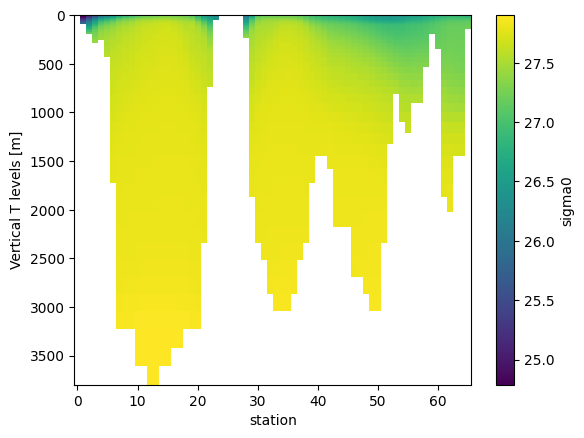

In [7]:
# Calculate potential density referenced to the sea surface using the Gibbs Sea Water Toolbox:
ds_osnap['sigma0'] = gsw.sigma0(SA=ds_osnap['sal'], CT=ds_osnap['temp'])

# Plot the time-mean potential density alomng the OSNAP section:
ds_osnap['sigma0'].mean(dim='time_counter').plot(yincrease=False)
plt.ylim([3800, 0])

### **Calculating Meridional Overturning Stream Functions along the OSNAP array**

**Finally, let's calculate the meridional overturning stream function in potential density coordinates along the OSNAP array using the `.compute_section_moc_tracer()` function:**

In [8]:
# Define potential density bins:
sigma0_bins = np.arange(21, 28.2, 0.01)

# Compute Total OSNAP diapycnal overturning stream function:
ds_osnap['moc_total'] = compute_section_moc_tracer(ds=ds_osnap,
                                                   tracer_name='sigma0',
                                                   tracer_bins=sigma0_bins,
                                                   dir='-1',
                                                   mask=None,
                                                   )

print(ds_osnap)

<xarray.Dataset> Size: 9MB
Dimensions:                (depth: 75, time_counter: 49, station: 66,
                            sigma0_bins: 719)
Coordinates:
  * depth                  (depth) float32 300B 0.5058 1.556 ... 5.902e+03
  * time_counter           (time_counter) datetime64[ns] 392B 1976-07-02 ... ...
  * station                (station) int64 528B 0 1 2 3 4 5 ... 61 62 63 64 65
    longitude              (station) float64 528B -56.8 -55.78 ... -9.802 -8.703
    latitude               (station) float64 528B 52.19 52.26 ... 56.76 56.69
  * sigma0_bins            (sigma0_bins) float64 6kB 28.19 28.18 ... 21.02 21.01
Data variables:
    velocity               (time_counter, depth, station) float32 970kB nan ....
    eddy_induced_velocity  (time_counter, depth, station) float32 970kB nan ....
    dz                     (time_counter, depth, station) float32 970kB nan ....
    dx                     (station) float64 528B 6.946e+04 ... 6.715e+04
    volume_transport       (time_cou

In [9]:
# Determine station indexes for OSNAP East section:
station_OWest_OEast = ds_osnap.station.where(ds_osnap.longitude <= -44).max()

# OSNAP East diapycnal overturning stream function:
mask_OEast = ds_osnap.station >= station_OWest_OEast
ds_osnap['moc_east'] = compute_section_moc_tracer(ds=ds_osnap,
                                                  tracer_name='sigma0',
                                                  tracer_bins=sigma0_bins,
                                                  dir='-1',
                                                  mask=mask_OEast,
                                                  )

# OSNAP West diapycnal overturning stream function:
mask_OWest = ds_osnap.station < station_OWest_OEast
ds_osnap['moc_west'] = compute_section_moc_tracer(ds=ds_osnap,
                                                  tracer_name='sigma0',
                                                  tracer_bins=sigma0_bins,
                                                  dir='-1',
                                                  mask=mask_OWest,
                                                  )

print(ds_osnap)

<xarray.Dataset> Size: 10MB
Dimensions:                (depth: 75, time_counter: 49, station: 66,
                            sigma0_bins: 719)
Coordinates:
  * depth                  (depth) float32 300B 0.5058 1.556 ... 5.902e+03
  * time_counter           (time_counter) datetime64[ns] 392B 1976-07-02 ... ...
  * station                (station) int64 528B 0 1 2 3 4 5 ... 61 62 63 64 65
    longitude              (station) float64 528B -56.8 -55.78 ... -9.802 -8.703
    latitude               (station) float64 528B 52.19 52.26 ... 56.76 56.69
  * sigma0_bins            (sigma0_bins) float64 6kB 28.19 28.18 ... 21.02 21.01
Data variables:
    velocity               (time_counter, depth, station) float32 970kB nan ....
    eddy_induced_velocity  (time_counter, depth, station) float32 970kB nan ....
    dz                     (time_counter, depth, station) float32 970kB nan ....
    dx                     (station) float64 528B 6.946e+04 ... 6.715e+04
    volume_transport       (time_co

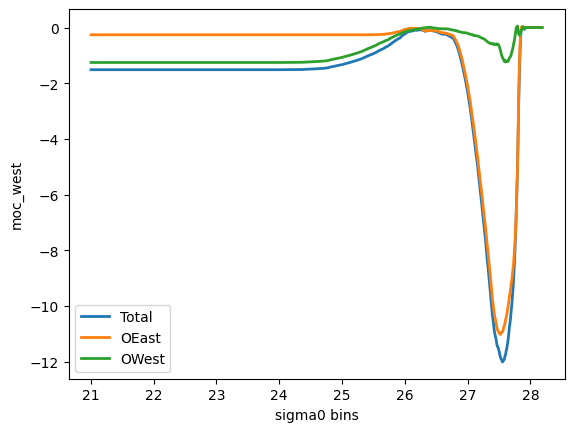

In [10]:
# Plot time-mean diapycnal overturning stream function along the OSNAP section:
ds_osnap['moc_total'].mean(dim='time_counter').plot(label='Total', lw=2)
ds_osnap['moc_east'].mean(dim='time_counter').plot(label='OEast', lw=2)
ds_osnap['moc_west'].mean(dim='time_counter').plot(label='OWest', lw=2)
plt.legend()

In [11]:
# Shutdown Dask Local Cluster:
client.close()
client.shutdown()